Autores: Alexandre Liermann, Gustavo Guerreiro e João Martinho.

# Implementação de Classificação de Imagens de Ressonância Magnética para Diagnóstico de Alzheimer Usando CNN em TensorFlow

Importações das bibliotecas necessárias

In [74]:
import tensorflow as tf
import pathlib

Definindo os diretórios do dataset

In [75]:
dir_dados = pathlib.Path('Dataset Alzheimer')
dir_treino = dir_dados / 'train'
dir_teste = dir_dados / 'test'

Carregando os imagens automaticamente para o TensorFlow.

In [76]:
img_height = 176
img_width  = 208
batch_size = 32

dataset_treino = tf.keras.utils.image_dataset_from_directory(
    dir_treino,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

dataset_val = tf.keras.utils.image_dataset_from_directory(
    dir_treino,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

dataset_teste = tf.keras.utils.image_dataset_from_directory(
    dir_teste,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False, 
)


print('Classes encontradas:', dataset_treino.class_names)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.
Found 1279 files belonging to 4 classes.
Classes encontradas: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


Normalizando a imagem para ficar mais natural para a CNN.

In [77]:

def normalizar_img(imagem, rotulo):
    imagem = tf.cast(imagem, tf.float32) / 255.0
    return imagem, rotulo

# 🔴 NÃO use mais isolar_luminancia aqui
dataset_treino = dataset_treino.map(normalizar_img)
dataset_val    = dataset_val   .map(normalizar_img)
dataset_teste  = dataset_teste .map(normalizar_img)


Configurando operações de cache e prefetch para aprimorar desempenho.

In [78]:
from tensorflow.data import AUTOTUNE

dataset_treino = dataset_treino.cache().shuffle(800).prefetch(AUTOTUNE)
dataset_val    = dataset_val   .cache().prefetch(AUTOTUNE)
dataset_teste  = dataset_teste .cache().prefetch(AUTOTUNE)


Fazendo data augmentation.

In [79]:
# from tensorflow.keras import layers
#
# data_augmentation = tf.keras.Sequential([
#     layers.RandomFlip("horizontal"),
# ])
#
# dataset_treino = dataset_treino.map(lambda x, y: (data_augmentation(x, training=True), y))

Isolando luminância.

In [80]:
def isolar_luminancia(imagem, rotulo):
    imagem = tf.image.rgb_to_grayscale(imagem)
    return imagem, rotulo

dataset_treino = dataset_treino.map(isolar_luminancia)
dataset_teste = dataset_teste.map(isolar_luminancia)

Iniciando a configuração do modelo.

In [81]:
from tensorflow.keras import models, layers

modelo = models.Sequential([
    layers.Conv2D(32, (4,4), activation='relu', padding='same',
                  input_shape=(img_height, img_width, 1)),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (4,4), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (4,4), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax'),
])



Compilando o modelo com a definição de otimizador (Adaptive Moment Estimation), perda e métricas.

In [82]:
modelo.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Definindo callback de EarlyStopping.

In [83]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

Treinando o modelo

In [84]:
history = modelo.fit(
    dataset_treino,
    validation_data=dataset_val,
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.4169 - loss: 21.8482

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "conv2d_18" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 176, 208, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 176, 208, 3), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

Avaliando os resultados do treino

In [ ]:
perda, acuracia = modelo.evaluate(dataset_teste)

print(f"Acurácia: {acuracia:.2f}")
print(f"Perda: {perda:.2f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.5207 - loss: 0.9336
Acurácia: 0.52
Perda: 0.93


Métricas mais avançadas com sklearn

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━

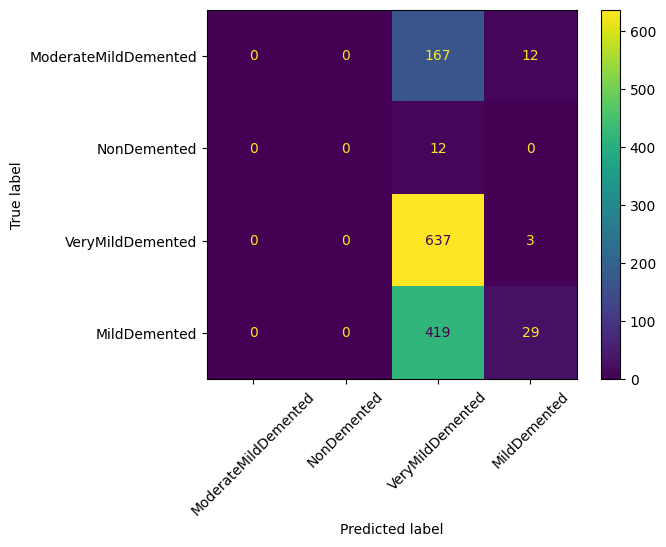

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from matplotlib import pyplot as plt

y_verdadeiro = []
y_previsto = []

for imagens, rotulos in dataset_teste:
    previsoes = modelo.predict(imagens)
    y_verdadeiro.extend(rotulos.numpy())
    y_previsto.extend(np.argmax(previsoes, axis=1))

classes = ['ModerateMildDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']
cm = confusion_matrix(y_verdadeiro, y_previsto)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(xticks_rotation=45)
plt.show()